In [ ]:
!pip install torchmetrics
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#use pyto_env kernel, pyto env.

import os
import json
import pandas as pd
import importlib
import pickle
import numpy as np

import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler,
                              SequentialSampler)
from torchmetrics import F1Score

from transformers import (AutoModel,
                          AutoConfig,
                          BertModel,
                          BertTokenizer,
                          BertForSequenceClassification,
                          get_linear_schedule_with_warmup)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_dir = "/content/drive/MyDrive/Thesis"
data_dir = os.path.join(project_dir,"Data")
model_dir = os.path.join(project_dir, "Models")
scripts_dir = os.path.join(project_dir, "Notebooks")

os.chdir(scripts_dir)

import common
from common import (ClassificationDataset,
                    BERT_fine_tune_validation,
                    BERT_fine_tune_train,
                    plot_confusion_matrix,
                   train_test_val_split,
                   get_weights)

#import common_metrics
#from common_metrics import plot_one_vs_one_roc

os.chdir(data_dir)

#L1 to integer map for loading categories into BERT
with open('target_idx.json') as f:
    data = f.read()
target_idx = json.loads(data)
idx_target = {target_idx[a]:a for a in target_idx.keys()}


# additional special tokens
with open('spec_tokens_ne.txt', 'rb') as file:
    spec_tokens = pickle.load(file)
spec_tokens = [a for a in spec_tokens if '-' not in a]

# CHANGE to k-split dataset
full_dataset = pd.read_csv('masked_data_set.csv', index_col = 0)


In [ ]:
# hyperparameters and variables universal to this project

max_len = 512
batch_size = 8
lr = 1e-4 #just to start with the pretrained, later will be annealed
n_warmup = 0
epochs = 20
n_classes = len(target_idx.keys())
metric = F1Score('multiclass', num_classes=n_classes, average = 'macro')
dropout = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = get_weights(full_dataset, target_idx, n_classes = n_classes)
weighted_cross_entropy_loss = torch.nn.CrossEntropyLoss(weight=weights)

# load the custom tokenizer
os.chdir(model_dir)
bert_tokenizer = BertTokenizer.from_pretrained('custom_bert_tokenizer')
                                              #additional_special_tokens = spec_tokens)

GE    0.911224
SP    0.941159
CN    0.956156
RU    1.039283
JP    1.065081
AR    1.087097
Name: Target, dtype: float64


In [ ]:
full_dataset.query("k == 3")

,Corpus,Target,Text,Length,k
12,ICLE,CN,"In the Past ten years, the development of info...",514,3
17,ICLE,GE,Television commercial always interrupts a film...,486,3
49,ICLE,JP,I don't think all of the <MISC> students must ...,666,3
58,ICLE,RU,The question of dreaming and imagination alway...,1009,3
71,ICLE,CN,1. \n\n Before specially talking about tourism...,640,3
...,...,...,...,...,...
16492,TOEFL11,AR,students now all over the world are receving t...,251,3
16497,TOEFL11,SP,"Throughout history, humans have competed and s...",517,3
16508,TOEFL11,AR,All peaple in this world injoy their life in t...,375,3
16512,TOEFL11,AR,"Most of young peoples nowadays, for some reaso...",383,3


In [ ]:
import torch.nn.functional as F
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class CustomModel(nn.Module):

    def __init__(self, num_labels, loss_fn, tokenizer, dropout = 0.10): #checkpoint, num_labels):
        super(CustomModel,self).__init__()
        self.num_labels = num_labels
        #Load Model
        self.config = AutoConfig.from_pretrained("bert-base-uncased")
        self.model = AutoModel.from_config(self.config) #
        self.model.resize_token_embeddings(len(tokenizer))
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(512, 1)
        self.layer_norm = nn.LayerNorm([768, 1])
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights

        self.loss_fn = loss_fn

    def forward(self, input_ids=None, token_type_ids = None, attention_mask=None,labels=None):
        #Extract outputs from the MLM model
        outputs = self.model(input_ids=input_ids, token_type_ids = token_type_ids, attention_mask=attention_mask)
        #Get Last hidden state
        sequence_output = self.dropout(outputs['last_hidden_state'])#[-1])
        # condense the 512 tokens into 1 dimension
        lin = self.linear(sequence_output.transpose(-2,-1))
        # layer norm
        normed = self.layer_norm(lin)
        # condense the features into 6 class values
        logits = self.classifier(normed.transpose(-2,-1)).squeeze(1)

        # calculate losses
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.long())

        return SequenceClassifierOutput(loss=loss,
                                        logits=logits,
                                        hidden_states=outputs.hidden_states,
                                        attentions=outputs.attentions)


In [ ]:
  # get train-val-test split indices
  k = len(full_dataset['k'].unique())
  ints = [a for a in range(k)]
  splits = []
  all_k_stats = []
  for a in ints:
    split = {}
    test = a
    split['test'] = test
    val = a + 1 if a + 1 in ints else 0
    split['val'] = val
    train = ints.copy()
    train.remove(test)
    train.remove(val)
    split['train'] = train
    splits.append(split)
splits

[{'test': 0, 'val': 1, 'train': [2, 3, 4, 5, 6, 7, 8, 9]},
 {'test': 1, 'val': 2, 'train': [0, 3, 4, 5, 6, 7, 8, 9]},
 {'test': 2, 'val': 3, 'train': [0, 1, 4, 5, 6, 7, 8, 9]},
 {'test': 3, 'val': 4, 'train': [0, 1, 2, 5, 6, 7, 8, 9]},
 {'test': 4, 'val': 5, 'train': [0, 1, 2, 3, 6, 7, 8, 9]},
 {'test': 5, 'val': 6, 'train': [0, 1, 2, 3, 4, 7, 8, 9]},
 {'test': 6, 'val': 7, 'train': [0, 1, 2, 3, 4, 5, 8, 9]},
 {'test': 7, 'val': 8, 'train': [0, 1, 2, 3, 4, 5, 6, 9]},
 {'test': 8, 'val': 9, 'train': [0, 1, 2, 3, 4, 5, 6, 7]},
 {'test': 9, 'val': 0, 'train': [1, 2, 3, 4, 5, 6, 7, 8]}]

<h1> First Round </h1>

In [ ]:
i = 9
split = splits[i]

# make dataloader objs
train_ds = ClassificationDataset(full_dataset.query(f"k == {split['train']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
val_ds = ClassificationDataset(full_dataset.query(f"k == {split['val']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)


train_dataloader = DataLoader(
                              train_ds,
                              sampler = RandomSampler(train_ds),
                              batch_size=batch_size)
validation_dataloader = DataLoader(
                              val_ds,
                              sampler = RandomSampler(val_ds),
                              batch_size = batch_size)

total_steps = len(train_dataloader)*epochs

In [ ]:
# set up model and training objects

bert_custom_model = CustomModel(
                              num_labels = n_classes,
                              loss_fn = weighted_cross_entropy_loss,
                              tokenizer = bert_tokenizer)
bert_custom_model.to(device)

optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)


In [ ]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optim_bert,
                                  base_lr = 1e-7,
                                  max_lr = 1e-3,
                                  step_size_up=1900,
                                  step_size_down=2050,
                                  mode='triangular',
                                  gamma=0.96,
                                  scale_fn=None,
                                  scale_mode='cycle',
                                  cycle_momentum=False,
                                  base_momentum=0.8,
                                  max_momentum=0.9,
                                  last_epoch= -1,
                                  verbose=True)

Adjusting learning rate of group 0 to 1.0000e-07.


In [ ]:
# # call training loop
stats_bert = BERT_fine_tune_train(bert_custom_model,
                train_dataloader,
                validation_dataloader,
                device = device,
                metric = metric,
                optimizer = optim_bert,
                scheduler = scheduler,
                epochs = epochs,
                lr = lr,
                n_warmup = n_warmup,
                save_path = os.path.join(model_dir, f"BERT_cyclic_k{str(i)}.pt")
                )

with open(f"train_stats_k{i}.pkl", "wb") as f:
  pickle.dump(stats_bert, f)

<h1> Second Round </h1>
Fine-tune on a second run, loading models from checkpoint and decreasing max learning rate.

In [ ]:
# call the training loop on each k-model so far,
# running cyclical learning rate with a lower ceiling and floor

os.chdir(model_dir)

i=9
epochs = 20
lr = 1e-5
# make dataloader objs
train_ds = ClassificationDataset(full_dataset.query(f"k == {split['train']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
val_ds = ClassificationDataset(full_dataset.query(f"k == {split['val']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
train_dataloader = DataLoader(
                              train_ds,
                              sampler = RandomSampler(train_ds),
                              batch_size=batch_size)
validation_dataloader = DataLoader(
                              val_ds,
                              sampler = RandomSampler(val_ds),
                              batch_size = batch_size)
total_steps = len(train_dataloader)*epochs

bert_custom_model = CustomModel(num_labels = n_classes,
                    loss_fn = weighted_cross_entropy_loss,
                    tokenizer = bert_tokenizer,
                    dropout = dropout)
bert_custom_model.to(device)
optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optim_bert,
                                  base_lr = 1e-8,
                                  max_lr = lr,
                                  step_size_up=1900,
                                  step_size_down=2050,
                                  mode='triangular',
                                  gamma=0.96,
                                  scale_fn=None,
                                  scale_mode='cycle',
                                  cycle_momentum=False,
                                  base_momentum=0.8,
                                  max_momentum=0.9,
                                  last_epoch= -1,
                                  verbose=True)

checkpoint = torch.load(f'BERT_cyclic_k{str(i)}.pt')
bert_custom_model.load_state_dict(checkpoint['model_state_dict'])
optim_bert.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
bert_custom_model.to(device)
optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optim_bert,
                                  base_lr = 1e-8,
                                  max_lr = lr,
                                  step_size_up=1900,
                                  step_size_down=2050,
                                  mode='triangular',
                                  gamma=0.96,
                                  scale_fn=None,
                                  scale_mode='cycle',
                                  cycle_momentum=False,
                                  base_momentum=0.8,
                                  max_momentum=0.9,
                                  last_epoch= -1,
                                  verbose=True)



Adjusting learning rate of group 0 to 1.0000e-08.
Adjusting learning rate of group 0 to 1.0000e-08.


In [ ]:
lr=1e-4
stats_bert = BERT_fine_tune_train(bert_custom_model,
                train_dataloader,
                validation_dataloader,
                device = device,
                metric = metric,
                optimizer = optim_bert,
                scheduler = scheduler,
                epochs = epochs,
                lr = lr,
                n_warmup = n_warmup,
                save_path = os.path.join(model_dir, f"BERT_cyclic_R2_k{str(i)}.pt")
                )

with open(f"train_stats_R2_k{str(i)}.pkl", "wb") as f:
  pickle.dump(stats_bert, f)

<h1> Return to BertForSequenceClassification Architecture </h1>

The custom model is not compatible with Captum and Shap interpretations.

Load the state dict from the Custom Model and retrain k3 for 20 epochs.

In [ ]:
# call the training loop on each k-model so far,
# running cyclical learning rate with a lower ceiling and floor

os.chdir(model_dir)

i=3
epochs = 20
lr = 1e-4
# make dataloader objs
train_ds = ClassificationDataset(full_dataset.query(f"k == {split['train']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
val_ds = ClassificationDataset(full_dataset.query(f"k == {split['val']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
train_dataloader = DataLoader(
                              train_ds,
                              sampler = RandomSampler(train_ds),
                              batch_size=batch_size)
validation_dataloader = DataLoader(
                              val_ds,
                              sampler = RandomSampler(val_ds),
                              batch_size = batch_size)
total_steps = len(train_dataloader)*epochs

In [ ]:
device

device(type='cuda')

In [ ]:
bert_custom_model = CustomModel(num_labels = n_classes,
                    loss_fn = weighted_cross_entropy_loss,
                    tokenizer = bert_tokenizer,
                    dropout = dropout)
#bert_custom_model.to(device)

checkpoint = torch.load(f'BERT_cyclic_R2_k{str(i)}.pt')
bert_custom_model.load_state_dict(checkpoint['model_state_dict'])
#optim_bert.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']
#bert_custom_model.to(device)
bert_R3 = BertForSequenceClassification(config = bert_custom_model.config)#.to(device)
bert_R3.bert.load_state_dict(bert_custom_model.model.state_dict())
del(bert_custom_model)
bert_R3.to(device)

optim_bert = AdamW(bert_R3.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optim_bert,
                                  base_lr = 1e-8,
                                  max_lr = lr,
                                  step_size_up=1900,
                                  step_size_down=2050,
                                  mode='triangular',
                                  gamma=0.96,
                                  scale_fn=None,
                                  scale_mode='cycle',
                                  cycle_momentum=False,
                                  base_momentum=0.8,
                                  max_momentum=0.9,
                                  last_epoch= -1,
                                  verbose=True)



Adjusting learning rate of group 0 to 1.0000e-08.


In [ ]:
bert_R3

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(22500, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
#lr=1e-4
stats_bert = BERT_fine_tune_train(bert_R3,
                train_dataloader,
                validation_dataloader,
                device = device,
                metric = metric,
                optimizer = optim_bert,
                scheduler = scheduler,
                epochs = epochs,
                lr = lr,
                n_warmup = n_warmup,
                save_path = os.path.join(model_dir, f"BERT_cyclic_R3_k{str(i)}.pt")
                )

with open(f"train_stats_R3_k{str(i)}.pkl", "wb") as f:
  pickle.dump(stats_bert, f)


======== Epoch 1 / 20 ========
Training...


RuntimeError: ignored

<h1> On Runtime Disconnect </h1>
If the runtime disconnects, load the model from checkpoint below, and resume training for the remaining number of epochs.

In [ ]:
os.chdir(model_dir)

bert_custom_model = CustomModel(num_labels = n_classes,
                    loss_fn = weighted_cross_entropy_loss,
                    tokenizer = bert_tokenizer,
                    dropout = dropout)
bert_custom_model.to(device)
optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)

checkpoint = torch.load('BERT_cyclic_R2_k9.pt')
bert_custom_model.load_state_dict(checkpoint['model_state_dict'])
optim_bert.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
# call training loop
i=9
epochs = 10
lr = 1e-5
# make dataloader objs
train_ds = ClassificationDataset(full_dataset.query(f"k == {split['train']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
val_ds = ClassificationDataset(full_dataset.query(f"k == {split['val']}"),
                                bert_tokenizer,
                                target_idx,
                                max_seq_len = max_len)
train_dataloader = DataLoader(
                              train_ds,
                              sampler = RandomSampler(train_ds),
                              batch_size=batch_size)
validation_dataloader = DataLoader(
                              val_ds,
                              sampler = RandomSampler(val_ds),
                              batch_size = batch_size)
total_steps = len(train_dataloader)*epochs

stats_bert = BERT_fine_tune_train(bert_custom_model,
                train_dataloader,
                validation_dataloader,
                device = device,
                metric = metric,
                optimizer = optim_bert,
                scheduler = scheduler,
                epochs = 5,
                lr = lr,
                n_warmup = n_warmup,
                save_path = os.path.join(model_dir, f"BERT_cyclic_R2_k{str(i)}.pt")
                )

with open(f"train_stats_R2_k{i}.pkl", "wb") as f:
  pickle.dump(stats_bert, f)

NameError: ignored


Running Validation...
  Accuracy: 0.63
  Validation Loss: 1.04
  Validation F1 Score: 0.599
  Validation took: 0:00:53

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.09
  Validation F1 Score: 0.580
  Validation took: 0:00:53

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.07
  Validation F1 Score: 0.602
  Validation took: 0:00:53

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.08
  Validation F1 Score: 0.580
  Validation took: 0:00:52

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.12
  Validation F1 Score: 0.543
  Validation took: 0:00:53

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.08
  Validation F1 Score: 0.594
  Validation took: 0:00:52

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.05
  Validation F1 Score: 0.597
  Validation took: 0:00:53

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.10
  Validation F1 Score: 0.583
  Validation took: 0:00:52

Running Validation...
  Accuracy: 0.62


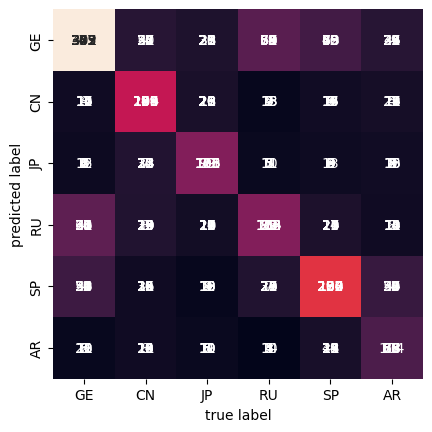

In [ ]:
# run test
os.chdir(model_dir)
# for each k
all_test_stats = {}
for i in range(10):
# load model from checkpoint

  bert_custom_model = CustomModel(num_labels = n_classes,
                      loss_fn = weighted_cross_entropy_loss,
                      tokenizer = bert_tokenizer,
                      dropout = dropout)
  bert_custom_model.to(device)
  optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)

  checkpoint = torch.load(f'BERT_cyclic_R2_k{i}.pt')
  bert_custom_model.load_state_dict(checkpoint['model_state_dict'])

  # get test set
  test_ds = ClassificationDataset(full_dataset.query(f"k == {i}"),
                                    bert_tokenizer,
                                    target_idx,
                                    max_seq_len = max_len)

  test_dataloader = DataLoader(
                            test_ds,
                            shuffle = False,
                            #sampler = RandomSampler(test_ds),
                            batch_size = batch_size)
# run testing
  test_stats = BERT_fine_tune_validation(bert_custom_model,
                                         test_dataloader,
                                         device,
                                         metric = metric)
  all_test_stats[i] = test_stats
  # confusion matrix
  mat = confusion_matrix(test_stats[1]['y_true'], test_stats[1]['y_pred'])
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.savefig(os.path.join(model_dir, f"k{i}_confusion_matrix"),
              dpi='figure',
              format='png',
              metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )



In [ ]:
with open(f"all_bert_test_stats.pkl", "wb") as f:
  pickle.dump(all_test_stats, f)

In [ ]:
with open('all_bert_test_stats.pkl', 'rb') as f:
  bert_test = pickle.load(f)

In [ ]:
[all_test_stats[a][1]['val_f1'].item() for a in all_test_stats.keys()]

[0.5991758108139038,
 0.579677164554596,
 0.6019929647445679,
 0.57963627576828,
 0.5427031517028809,
 0.5939373970031738,
 0.5974612832069397,
 0.5826840400695801,
 0.5962331891059875,
 0.5251408219337463]

<h1> k =3 Only </h1>


Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.08
  Validation F1 Score: 0.605
  Validation took: 0:00:50


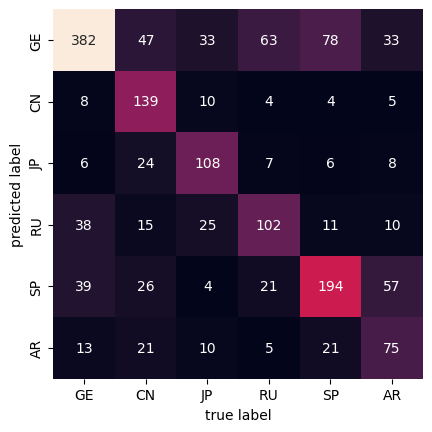

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

i = 3
bert_custom_model = CustomModel(num_labels = n_classes,
                    loss_fn = weighted_cross_entropy_loss,
                    tokenizer = bert_tokenizer,
                    dropout = dropout)
bert_custom_model.to(device)
optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)

checkpoint = torch.load(f'BERT_cyclic_R2_k{i}.pt')
bert_custom_model.load_state_dict(checkpoint['model_state_dict'])

# get test set
test_ds = ClassificationDataset(full_dataset.query(f"k == {i}"),
                                  bert_tokenizer,
                                  target_idx,
                                  max_seq_len = max_len)

test_dataloader = DataLoader(
                          test_ds,
                          shuffle = False,
                          #sampler = RandomSampler(test_ds),
                          batch_size = batch_size)
# run testing
test_stats = BERT_fine_tune_validation(bert_custom_model,
                                        test_dataloader,
                                        device,
                                        metric = metric)
#all_test_stats[i] = test_stats
# confusion matrix
mat = confusion_matrix(test_stats[1]['y_true'], test_stats[1]['y_pred'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=target_idx.keys(), yticklabels=target_idx.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig(os.path.join(model_dir, f"k{i}_confusion_matrix"),
            dpi='figure',
            format='png',
            metadata=None,
      bbox_inches=None, pad_inches=0.1,
      facecolor='auto', edgecolor='auto',
      backend=None,
      )

#with open(f"all_bert_test_stats.pkl", "wb") as f:
#  pickle.dump(all_test_stats, f)

In [ ]:
test_stats

(tensor(1.0794, device='cuda:0'),
 {'avg_val_loss': 1.0793956518173218,
  'val_time': '0:00:50',
  'val_f1': tensor(0.6053),
  'avg_flat_acc': 0.6056763285024155,
  'logits': tensor([[-2.9875,  7.4378,  3.4776, -2.9363, -3.6863, -1.3312],
          [ 4.8527, -2.8044, -3.7755,  0.8328,  1.7613,  0.0478],
          [ 0.2455, -0.1269,  5.3038,  0.3116, -1.1228, -3.3325],
          ...,
          [-1.6292,  1.4270, -0.8575, -3.1931, -2.0782,  6.0564],
          [-1.4113,  0.3886, -2.4366, -3.7093,  2.1271,  5.2246],
          [-2.4929,  4.4981,  1.9294, -6.0035, -0.7687,  0.3425]]),
  'y_pred': tensor([1, 0, 2,  ..., 5, 5, 1], dtype=torch.int32),
  'y_true': tensor([1, 0, 2,  ..., 5, 5, 1], dtype=torch.int32)})

In [ ]:
y_pred = np.expand_dims(test_stats[1]['y_pred'].numpy(), axis =1)
y_true  = np.expand_dims(test_stats[1]['y_true'].numpy(), axis =1)

In [ ]:
y_true

array([[1],
       [0],
       [2],
       ...,
       [5],
       [5],
       [1]], dtype=int32)

In [ ]:
np_array = np.concatenate([y_pred, y_true], axis = 1)

In [ ]:
np_array

array([[1, 1],
       [0, 0],
       [2, 2],
       ...,
       [5, 5],
       [5, 5],
       [1, 1]], dtype=int32)

In [ ]:
model_comparison = pd.DataFrame(np_array, columns = ['BERT_pred', 'Label'])
model_comparison['Target'] = model_comparison['Label'].apply(lambda x: idx_target[x])

In [ ]:
c = model_comparison.BERT_pred == model_comparison.Label
model_comparison['BERT_correct'] = c
model_comparison

,BERT_pred,Label,Target,BERT_correct
0,1,1,CN,True
1,0,0,GE,True
2,2,2,JP,True
3,3,3,RU,True
4,1,1,CN,True
...,...,...,...,...
1647,5,5,AR,True
1648,0,4,SP,False
1649,5,5,AR,True
1650,5,5,AR,True


In [ ]:
model_comparison.to_csv('model_comparison.csv')

In [ ]:
y_pred

NameError: ignored